In [1]:
%pylab inline

%load_ext autoreload
%autoreload 2

from pyotf.otf import SheppardPSF, HanserPSF
from pyotf.utils import easy_fft, easy_ifft

from easy_plot import easy_plot
plt.set_cmap("inferno")

Populating the interactive namespace from numpy and matplotlib


<Figure size 432x288 with 0 Axes>

In [2]:
# We'll use a 1.27 NA water dipping objective imaging in water
psf_params = dict(
    na=1.27,
    ni=1.33,
    wl=0.585,
    size=128,
    vec_corr="none"
)

# Set the Nyquist sampling rate
nyquist_sampling = psf_params["wl"] / psf_params["na"] / 4

# our oversampling factor, must be odd for easy integration (for peaked symmetrical funtions the kernel must be odd)
oversample_factor = 1

# Over sample to 
psf_params["res"] = nyquist_sampling * 0.45 / oversample_factor
psf_params["size"] *= oversample_factor

In [3]:
psf = SheppardPSF(**psf_params).PSFi

In [4]:
# centered coordinate system.
x = (np.arange(psf_params["size"]) - (psf_params["size"] + 1) // 2) * psf_params["res"]

In [5]:
zz, xx = meshgrid(x, x, indexing="ij")

In [6]:
freq = 2 * pi * psf_params["ni"] / psf_params["wl"]
alpha = np.arcsin(psf_params["na"] / psf_params["ni"])
print(freq, np.rad2deg(alpha))
s = np.zeros_like(xx * 1j)
for theta in (-alpha, 0, alpha):
    s += exp(1j*((xx * sin(theta) + zz * cos(theta)) * freq))

14.284848647092053 72.72437394563345


In [7]:
sim_psf = psf * (abs(s)**2)[:, None]

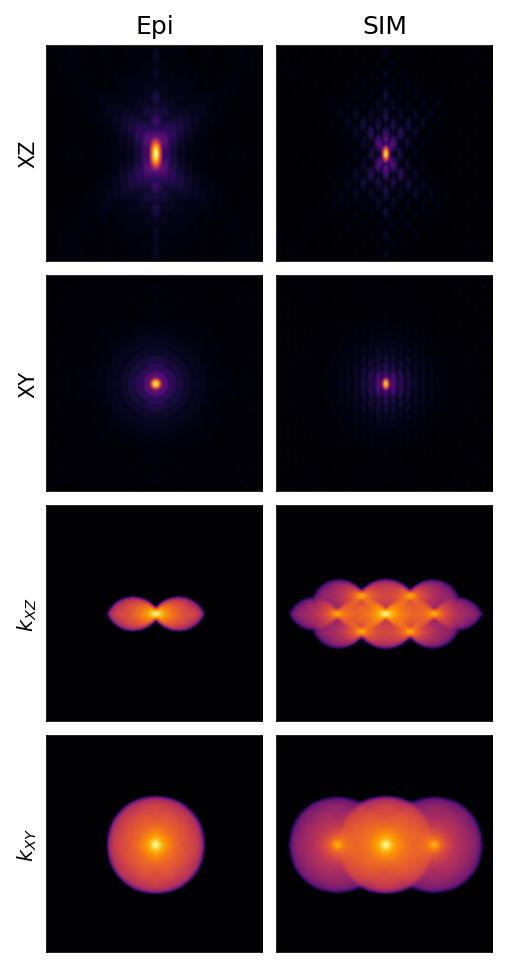

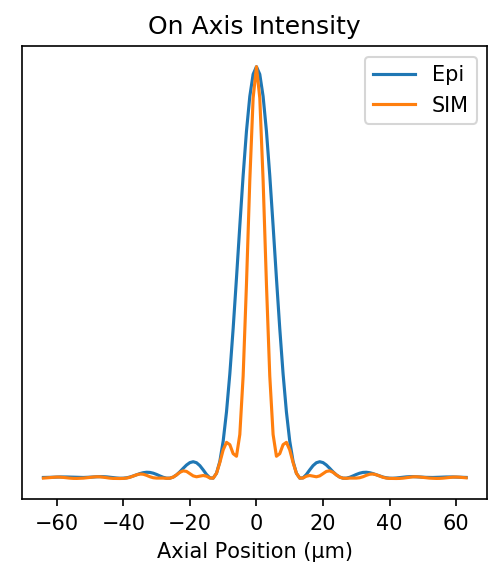

In [8]:
easy_plot((psf, sim_psf), ("Epi", "SIM",), oversample_factor=1, gam=0.5)

In [9]:
zz, yy, xx = x[:, None, None], x[None, :, None], x[None, None, :]

In [10]:
freq = 2 * pi * psf_params["ni"] / psf_params["wl"]
alpha = np.arcsin(psf_params["na"] / psf_params["ni"])
print(freq, np.rad2deg(alpha))
sim_psf = np.zeros_like(psf)
for orientation in (0, 2 * pi / 3, 4 * pi / 3):
    s = np.zeros_like(psf, dtype=complex)
    for strength, theta in zip((1, 0.5, 1), (-alpha, 0, alpha)):
        s += strength * exp(1j*(((xx * cos(orientation) + yy * sin(orientation)) * sin(theta) + zz * cos(theta)) * freq))
    sim_psf += psf * (abs(s)**2)

14.284848647092053 72.72437394563345


In [11]:
otf = abs(easy_fft(psf))**2

In [12]:
w = otf.max() / 100
wiener_otf = otf / (otf + w)
# wiener_otf = otf > 1e-16
wiener_psf = easy_ifft(wiener_otf).real

In [13]:
freq = 2 * pi * psf_params["ni"] / psf_params["wl"]
alpha = np.arcsin(psf_params["na"] / psf_params["ni"])
print(freq, np.rad2deg(alpha))
wiener_sim_psf = np.zeros_like(wiener_psf)
for orientation in (0, 2 * pi / 3, 4 * pi / 3):
    # s = np.zeros_like(xx * 1j)
    s = exp(1j * zz * freq) * np.ones(psf.shape[:2], dtype=complex)
    for theta in (-alpha, alpha):
        s += strength * exp(1j*(((xx * cos(orientation) + yy * sin(orientation)) * sin(theta) + zz * cos(theta)) * freq))
    wiener_sim_psf += wiener_psf * (abs(s)**2)
wiener_sim_psf -= 8 * wiener_psf

14.284848647092053 72.72437394563345


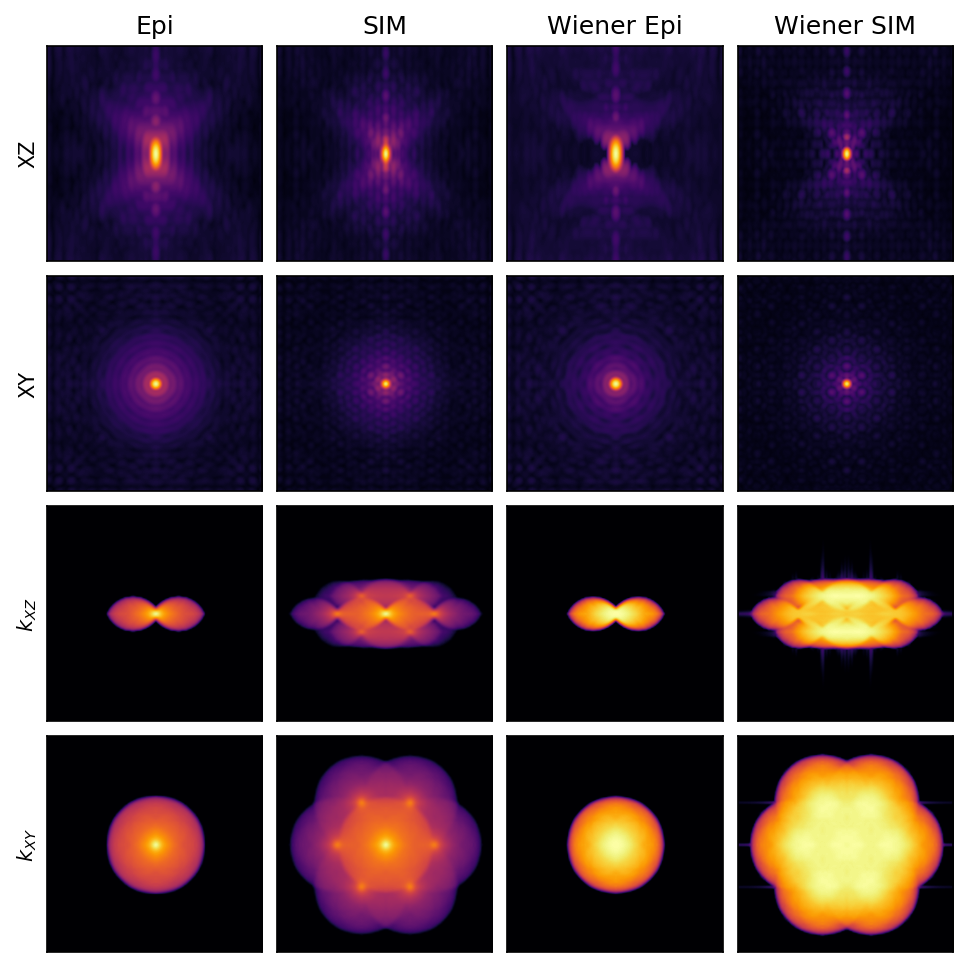

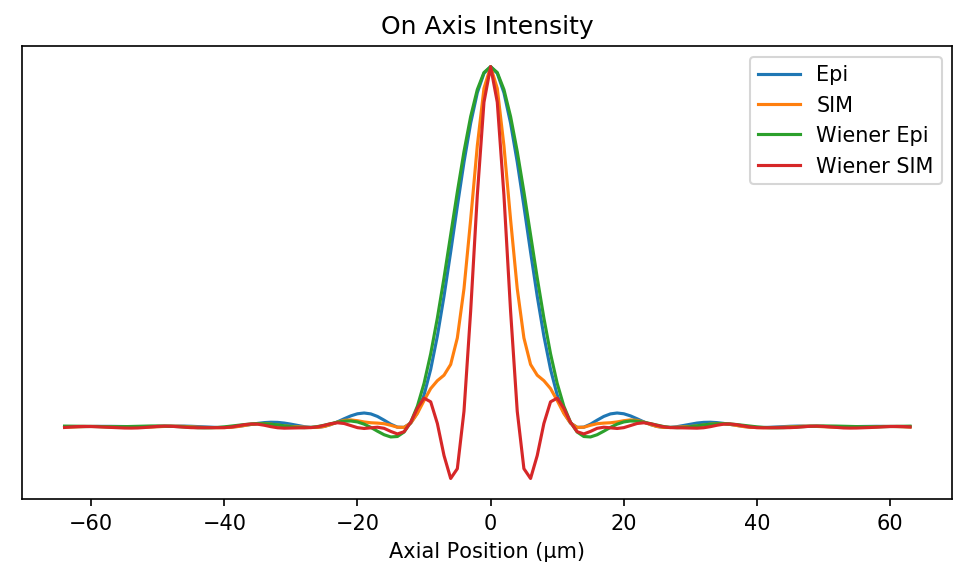

In [14]:
easy_plot((psf, sim_psf, wiener_psf, wiener_sim_psf), ("Epi", "SIM", "Wiener Epi", "Wiener SIM",), oversample_factor=1)

In [15]:
freq = 2 * pi * psf_params["ni"] / psf_params["wl"]
s = exp(1j * zz * freq) * np.ones(psf.shape[1:], dtype=complex)
for orientation in (0, pi / 2):
    rr = xx * cos(orientation) + yy * sin(orientation)
    for theta in (-alpha, alpha):
        s += exp(1j*((rr * sin(theta) + zz * cos(theta)) * freq))
lattice_sim_psf = wiener_psf* (abs(s)**2)

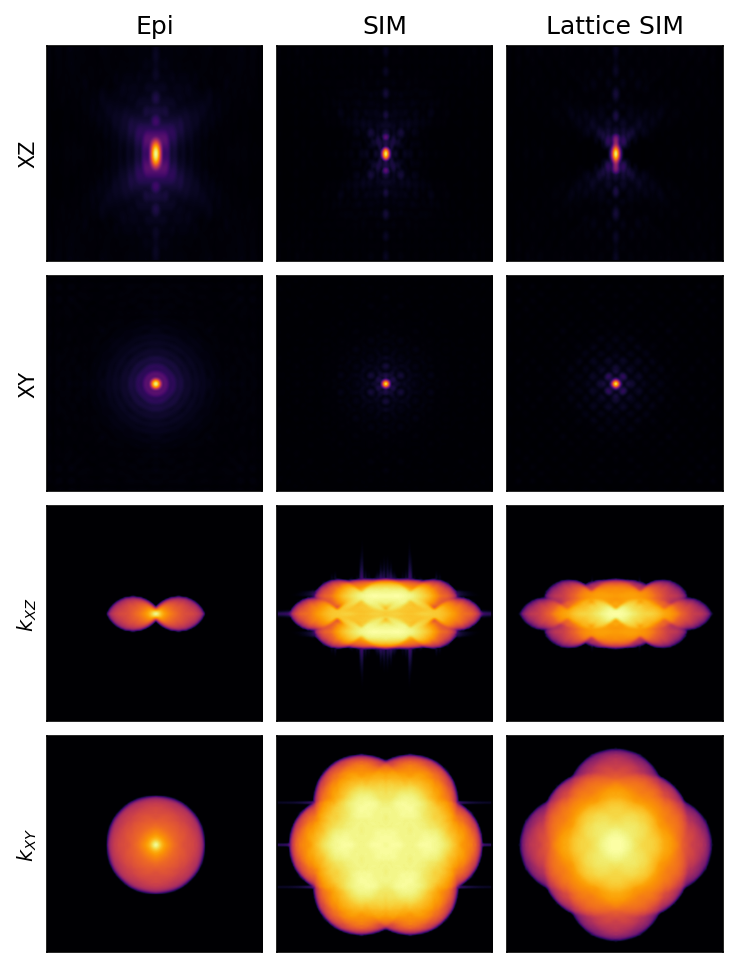

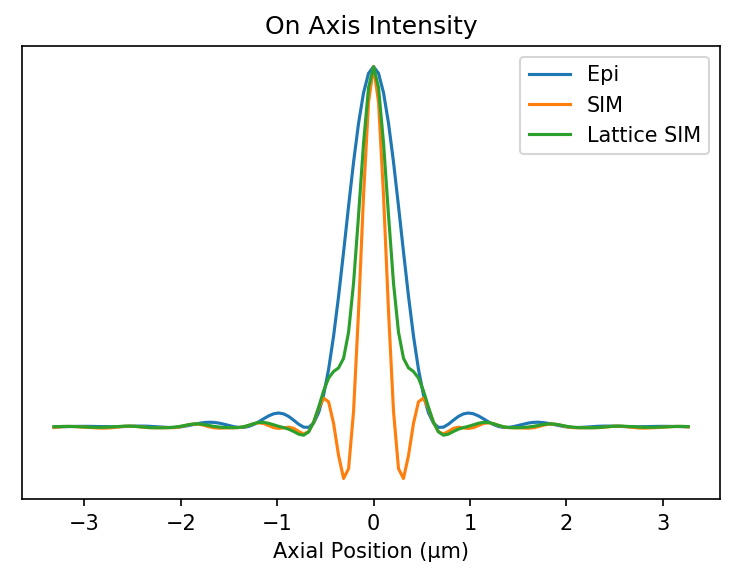

In [16]:
easy_plot((psf, wiener_sim_psf, lattice_sim_psf,), ("Epi", "SIM", "Lattice SIM"), oversample_factor=1, res=psf_params["res"], gam=0.5)

/Users/david/miniconda3/envs/sandbox/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


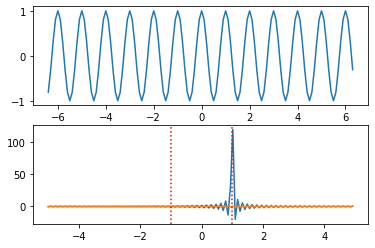

In [17]:
fig, (ax_real, ax_freq) = plt.subplots(2)
dx = 0.1
n = 128
x = (np.arange(n) - (n + 1) // 2) * dx
y = exp(2j * pi * x)
fx = (np.arange(n) - (n + 1) // 2)/ dx / n
fy = easy_fft(y)
ax_real.plot(x, y)
ax_freq.plot(fx, fy.real)
ax_freq.plot(fx, fy.imag)
for i in (-1, 1):
    ax_freq.axvline(i, c="r", ls=":")

In [18]:
from pyotf.microscope import WidefieldMicroscope, BaseSIMMicroscope, SIM2DMicroscope, SIM3DMicroscope, LatticeSIMMicroscope, ConfocalMicroscope

In [19]:
base_psf_params = dict(
    model="sheppard",
    oversample_factor=oversample_factor,
    pixel_size=psf_params["res"]
)

base_psf_params.update(psf_params)

sim_psf_params = dict(
    na_exc=None,
    wl_exc=0.561,
    wiener=10,
)

sim_psf_params.update(base_psf_params)

In [20]:
base_psf_params

{'model': 'sheppard',
 'oversample_factor': 1,
 'pixel_size': 0.05182086614173228,
 'na': 1.27,
 'ni': 1.33,
 'wl': 0.585,
 'size': 128,
 'vec_corr': 'none',
 'res': 0.05182086614173228}

In [21]:
orientations = (0, 2 * pi / 3, 4 * pi / 3)

In [22]:
{**sim_psf_params, "na_exc": 0.5}

{'na_exc': 0.5,
 'wl_exc': 0.561,
 'wiener': 10,
 'model': 'sheppard',
 'oversample_factor': 1,
 'pixel_size': 0.05182086614173228,
 'na': 1.27,
 'ni': 1.33,
 'wl': 0.585,
 'size': 128,
 'vec_corr': 'none',
 'res': 0.05182086614173228}

In [23]:
epi = WidefieldMicroscope(**base_psf_params).PSF

ls_psf = LatticeSIMMicroscope(**sim_psf_params).PSF

sim2d_psf = SIM2DMicroscope(orientations=orientations, **sim_psf_params).PSF

con_psf = ConfocalMicroscope(**base_psf_params, pinhole_size=1, wl_exc=0.561).PSF
airy_psf = ConfocalMicroscope(**base_psf_params, pinhole_size=0, wl_exc=0.561).PSF

os_sim_psf = SIM2DMicroscope(orientations=(0,), **{**sim_psf_params, "na_exc": sim_psf_params["na"] / 2}).PSF

sim3d_psf = SIM3DMicroscope(orientations=orientations, dc_suppress=True, **sim_psf_params).PSF

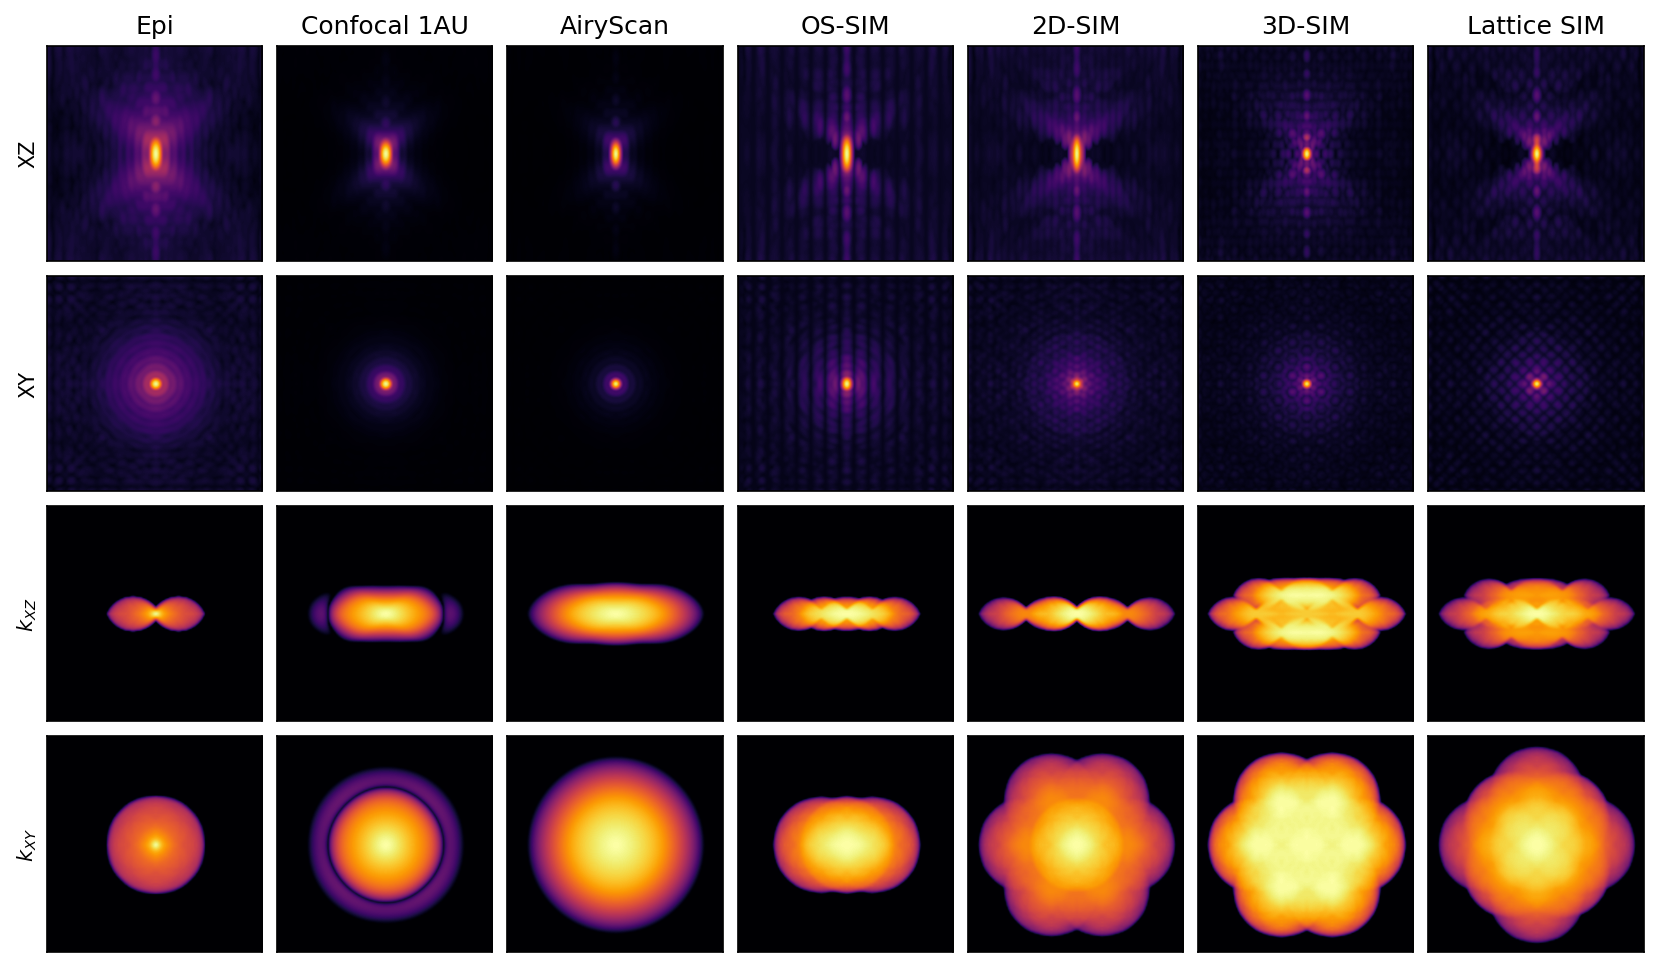

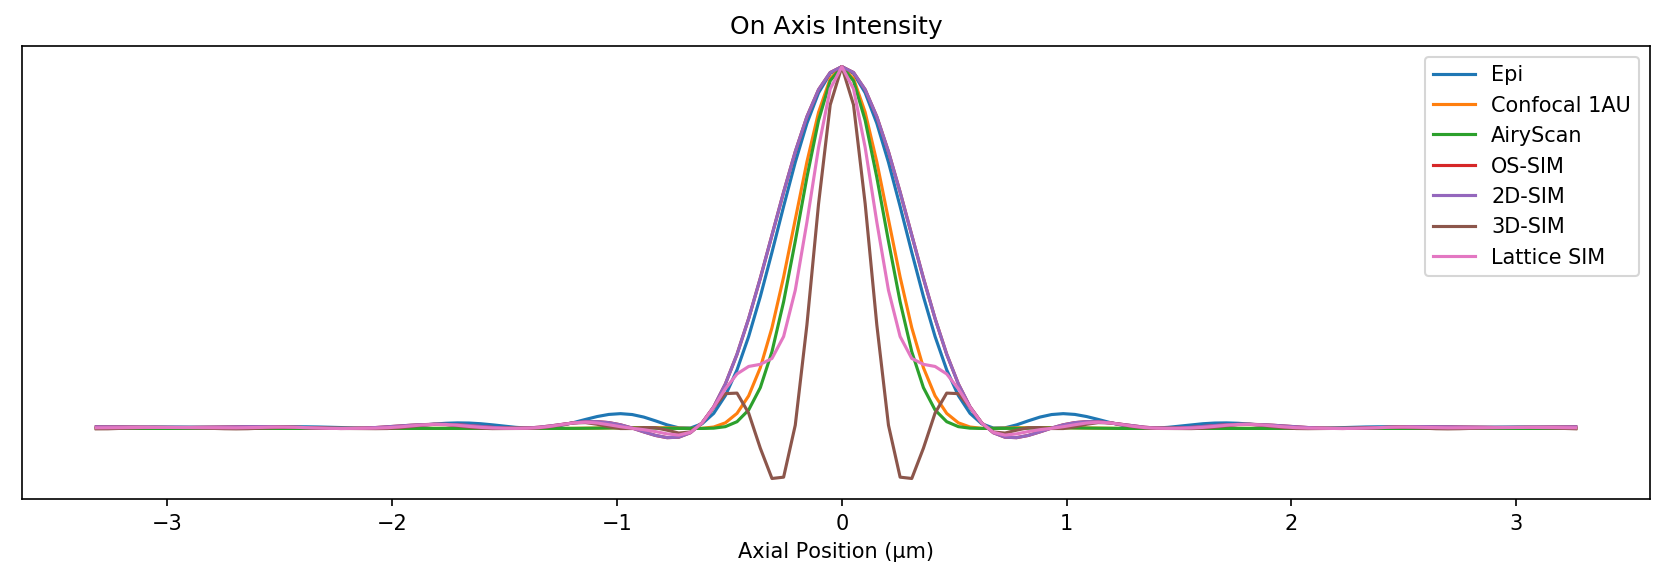

In [24]:
easy_plot(
    (epi, con_psf, airy_psf, os_sim_psf, sim2d_psf, sim3d_psf, ls_psf),
    ("Epi", "Confocal 1AU", "AiryScan", "OS-SIM", "2D-SIM", "3D-SIM", "Lattice SIM"),
    oversample_factor=1,
    res=psf_params["res"]
)

In [36]:
epi = WidefieldMicroscope(**{**base_psf_params, "model": "hanser", "oversample_factor": 5}).PSF

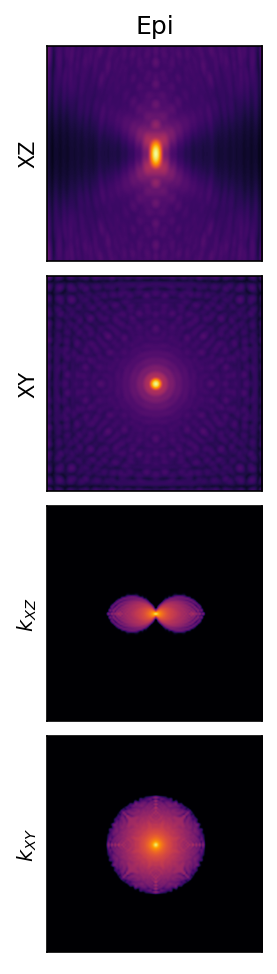

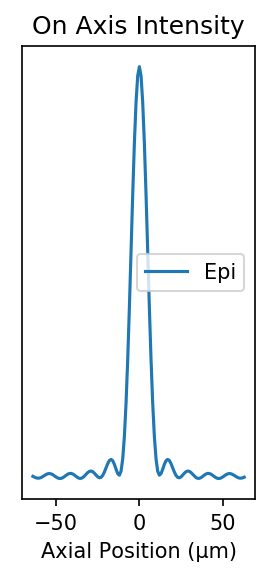

In [37]:
easy_plot((epi, ), ("Epi", ), 1)

In [38]:
epi.shape

(128, 128, 128)

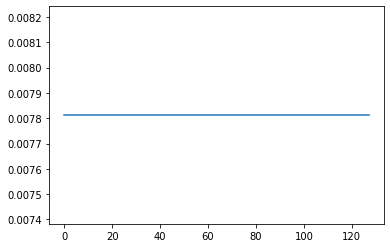

In [35]:
plot(epi.sum((1,2)))

In [39]:

    from mpl_toolkits.axes_grid1 import ImageGrid

In [41]:
plt.Figure()

/Users/david/miniconda3/envs/sandbox/lib/python3.6/site-packages/IPython/lib/pretty.py:695: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  output = repr(obj)


RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f